<a href="https://colab.research.google.com/github/yelangsung/Deep-Learning-Autonomous-Driving-Car/blob/main/Autonomous-Driving-Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<STEP 1> Google 드라이브 연결, 이미지 파일 압축 풀기

In [ ]:
epochN = None; learnRate = None                                                 # epochN = 2~10, learnRate = 0.0005/0.0010/0.0015/0.0020/0.0025
import glob, zipfile
from google.colab import drive
drive.mount('/content/drive')                                                   # Google Drive 연결
imageDir = 'Car'; outDir = '/content/drive/MyDrive/'+imageDir
fileList = glob.glob(outDir+'/*.zip'); print(f'Project N : {len(fileList)} 개')
for t in fileList:
    u = t.split('/'); v = u[-1]; w = v.split('.'); p = w[-2]; print(p)          # file list 생성
project = input('Project Name :')
if project == '': project = p
local_zip =  '/content/drive/MyDrive/'+imageDir+'/'+project+'.zip'; print(local_zip)
zip_ref = zipfile.ZipFile(local_zip, 'r'); zip_ref.extractall(); zip_ref.close()

<STEP 2> 라이브러 Import

In [ ]:
import os
import sys
import random
import fnmatch
import pickle
import time
import numpy as np
import cv2 as cv                                 # Open Cv 영상처리 라이브러리
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
from PIL import Image

print(f'Python Version:     {sys.version}')                                     # Python Version
print(f'OpenCV version:     {cv.__version__}')                                  # Open CV version
print(f'Pytorch version:    {torch.__version__}')                               # Pytorch version

Python Version:     3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
OpenCV version:     4.6.0
Pytorch version:    1.13.0+cu116


<STEP 3> 이미지 데이터 조향각 추출

In [ ]:
dataDir = '/content/'+project                                                   # colab 내부 프로젝트 디렉터리
with open(f'{dataDir}/{project}.pickle', 'rb') as f:                            # pickle
    x_exam_Image = pickle.load(f)                                               # 시험 이미지 파일 이름 list
    x_valid_Image = pickle.load(f)                                              # 평가 이미지 파일 이름 list
    x_train_Image = pickle.load(f)                                              # 훈련 이미지 파일 이름 list
    p = pickle.load(f)                                                          # Parameter list
if epochN == None:    epochN =    p[0]                                          # 학습회수 2 ~ 10
if learnRate == None: learnRate = p[1]                                          # 학습 비율 0.0005/0.0010/0.0015/0.0020/0.0025
#-------------------------------------------------------------------------------
y_exam_Angle=[]
y_valid_Angle=[]
y_train_Angle = []
for f in x_exam_Image:                   # 시험용 이미지 파일 이름에서 각도값
    y_exam_Angle.append(int(f[-7:-4]))
for f in x_valid_Image:                  # 평가용 이미지 파일 이름에서 각도값
    y_valid_Angle.append(int(f[-7:-4]))
for f in x_train_Image:                  # 훈련용 이미지 파일 이름에서 각도값
    y_train_Angle.append(int(f[-7:-4]))

<STEP 4> Nvidia CNN 모델 구성, 딥러닝

cpu is available

시험 이미지 개수: 5
평가 이미지 개수: 26
훈련 이미지 개수: 113
학습 비율= 0.001
학습 회수= 3

[  1/300] train_loss: 553.19952 valid_loss: 573.76117
Validation loss decreased (inf --> 573.761169).  Saving model ...
[  2/300] train_loss: 552.71765 valid_loss: 570.73602
Validation loss decreased (573.761169 --> 570.736023).  Saving model ...
[  3/300] train_loss: 550.29144 valid_loss: 561.75128
Validation loss decreased (570.736023 --> 561.751282).  Saving model ...
[  4/300] train_loss: 542.77643 valid_loss: 542.93140
Validation loss decreased (561.751282 --> 542.931396).  Saving model ...
[  5/300] train_loss: 527.20911 valid_loss: 518.30493
Validation loss decreased (542.931396 --> 518.304932).  Saving model ...
[  6/300] train_loss: 507.55478 valid_loss: 485.39636
Validation loss decreased (518.304932 --> 485.396362).  Saving model ...
[  7/300] train_loss: 481.14825 valid_loss: 441.25775
Validation loss decreased (485.396362 --> 441.257751).  Saving model ...
[  8/300] train_loss: 442.64575 val

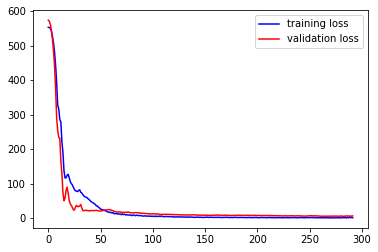

In [ ]:
# Pytorch device 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

# Nvidia CNN 모델 구성 ---------------------------------------------------------
class NvidiaModel(nn.Module):
    def __init__(self):
      super(NvidiaModel, self).__init__()

      # elu=Expenential Linear Unit, similar to leaky Relu
      # skipping 1st hiddel layer (nomralization layer), as we have normalized the data

      # Convolution Layers
      self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(5, 5), stride=(2, 2)),
        nn.ELU(inplace=True),
        nn.Conv2d(in_channels=24, out_channels=36, kernel_size=(5, 5), stride=(2, 2)),
        nn.ELU(inplace=True),
        nn.Conv2d(in_channels=36, out_channels=48, kernel_size=(5, 5), stride=(2, 2)),
        nn.ELU(inplace=True),
        nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3, 3)),
        nn.ELU(inplace=True),
        nn.Dropout(0.2),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)),
        nn.ELU(inplace=True)
      )

      # Fully Connected Layers
      self.layer2 = nn.Sequential(
        # nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(in_features=18 * 64, out_features=100),
        nn.ELU(inplace=True),
        nn.Linear(in_features=100, out_features=50),
        nn.ELU(inplace=True),
        nn.Linear(in_features=50, out_features=10),
        nn.ELU(inplace=True)
      )

      # Output Layer
      self.layer3 = nn.Sequential(
        nn.Linear(in_features=10, out_features=1)
      )

    def forward(self, x):
      x = self.layer1(x)
      x = x.view(x.shape[0], -1)
      x = self.layer2(x)
      x = self.layer3(x)

      return x


#-------------------------------------------------------------------------------
def imgPaths(fGroup):
    r = []
    for filename in fGroup:
        r.append(os.path.join(dataDir, filename))                               # 파일 경로(path)를 화일 이름 앞에 부착하여 리스트에 추가
    return(r)

# 학습 데이터 생성 -------------------------------------------------------------
class CustomDataset(Dataset):
    def __init__(self, imageList, angleList):
        self.imageList = imgPaths(imageList)
        self.angleList = angleList

        for i in range(len(imageList)):
            # print(i, self.imageList[i])
            image = cv.imread(self.imageList[i])
            image = image / 255

            self.imageList[i] = image

    def __len__(self):
        return len(self.imageList)

    def __getitem__(self, index):
        images = torch.FloatTensor(self.imageList[index]).permute(2,0,1)
        angles = torch.FloatTensor([self.angleList[index]])

        return images, angles


#-------------------------------------------------------------------------------
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path=f'{outDir}/{project}_model_check.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        # torch.save(model, self.path)
        self.val_loss_min = val_loss

# 모델 학습 --------------------------------------------------------------------
def learnProc():
  model = NvidiaModel().to(device)

  train_dataset = CustomDataset(x_train_Image, y_train_Angle)
  train_loader = DataLoader(train_dataset, batch_size=len(x_train_Image))

  valid_dataset = CustomDataset(x_valid_Image, y_valid_Angle)
  valid_loader = DataLoader(valid_dataset, batch_size=len(x_valid_Image))

  optimizer = optim.Adam(model.parameters(), lr=learnRate)
  criterion = nn.MSELoss().to(device)

  early_stopping = EarlyStopping(patience=30, verbose=True)

  # EPOCHS = epochN
  EPOCHS = 300
  train_losses = []
  valid_losses = []
  avg_train_losses = []
  avg_valid_losses = []
  for epoch in range(1, EPOCHS + 1):
      # 학습
      model.train()

      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()

          output = model(data)

          loss = criterion(output.to(torch.float32), target.to(torch.float32))
          loss.backward()
          optimizer.step()

          train_losses.append(loss.item())

      # 검증
      model.eval()

      with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            loss = criterion(output.to(torch.float32), target.to(torch.float32))

            valid_losses.append(loss.item())

      train_loss = np.average(train_losses)
      valid_loss = np.average(valid_losses)
      avg_train_losses.append(train_loss)
      avg_valid_losses.append(valid_loss)

      epoch_len = len(str(EPOCHS))

      print_msg = (f'[{epoch:>{epoch_len}}/{EPOCHS:>{epoch_len}}] ' +
                      f'train_loss: {train_loss:.5f} ' +
                      f'valid_loss: {valid_loss:.5f}')

      print(print_msg)

      train_losses = []
      valid_losses = []

      early_stopping(valid_loss, model)

      if early_stopping.early_stop:
          print("Early stopping")
          break

  return {'loss':avg_train_losses, 'val_loss':avg_valid_losses}

# 학습 시작---------------------------------------------------------------------
print()
print('시험 이미지 개수:',len(x_exam_Image))
print('평가 이미지 개수:',len(x_valid_Image))
print('훈련 이미지 개수:',len(x_train_Image))
print('학습 비율=', learnRate)
print('학습 회수=', epochN)
print()
startTime = time.time()                                                         # 학습 시작 시간 저장
history = learnProc()                                                           # 학습 시작
elapsedTime = int(time.time() - startTime)                                      # 학습 경과 시간 저장
#-------------------------------------------------------------------------------
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(['training loss', 'validation loss'])
plt.savefig(f'{outDir}/{project}_result.png')                                   # plot 이미지 저장

<STEP 5> 학습 결과 표시, 테스트 파일 각도 예측

pred [[-29.05752  ]
 [ -9.643948 ]
 [  0.3519417]
 [ 14.898224 ]
 [ 24.893166 ]]
target [[-25.]
 [-10.]
 [  0.]
 [ 16.]
 [ 27.]]

표준 편차: 4.5
회귀 결정 계수: 98.68%
학습 소요 시간: 2 분 46 초


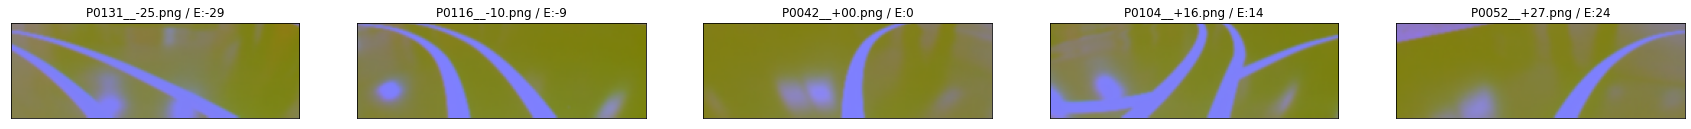

In [ ]:
def resultShow():
  test_dataset = CustomDataset(x_exam_Image, y_exam_Angle)
  test_loader = DataLoader(test_dataset, batch_size=len(x_exam_Image))

  model = NvidiaModel().to(device)
  model.load_state_dict(torch.load(f'{outDir}/{project}_model_check.pt'))
  # model = torch.load(f'{outDir}/{project}_model_check.pt')
  model.eval()

  y_pred = []
  y_target = []

  with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            print('pred', output.to(device).numpy())
            print('target', target.to(device).numpy())

            for output_data, target_data in zip(output.to(device).numpy(), target.to(device).numpy()):
              y_pred.append(output_data)
              y_target.append(target_data)

  mse = mean_squared_error(y_target, y_pred)
  r2s = r2_score(y_target, y_pred)
  #-----------------------------------------------------------------------------
  print('\n표준 편차:', f'{mse:.2}')
  print('회귀 결정 계수:', f'{r2s:.2%}')
  #-----------------------------------------------------------------------------
  fig, axes = plt.subplots(1, len(x_exam_Image), figsize=(30, 2+3))
  xTImg = imgPaths(x_exam_Image)                                                # add 경로
  for x, c in enumerate(xTImg):
      axes[x].imshow(Image.open(c))
      t = x_exam_Image[x] +' / E:'+str(int(y_pred[x]))
      axes[x].set_title(t)
      axes[x].xaxis.set_ticks([])
      axes[x].yaxis.set_ticks([])

if len(x_exam_Image): resultShow()
print("소요 시간:", int(elapsedTime/60), '분', elapsedTime%60, '초' )      #